### Investigation of Top Mass Reweighting

In [227]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [228]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

In [229]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [230]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

In [231]:
data_dir = 'DCTRFitting/'

In [232]:
default_had_mass = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,0]

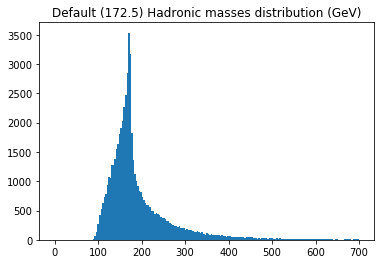

In [233]:
plt.hist(default_had_mass, bins = np.linspace(0,700,200))
plt.title("Default (172.5) Hadronic masses distribution (GeV)")
plt.show()

In [234]:
truth_had_mass = np.load(data_dir+ 'part_varmass_6j_obs.npy')[:,0][:len(default_had_mass)]

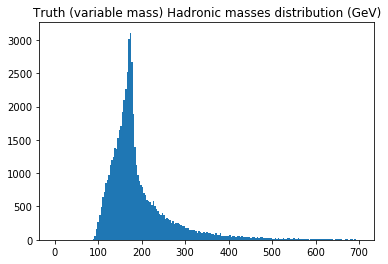

In [272]:
plt.hist(truth_had_mass, bins = np.linspace(0,700,200))
plt.title("Truth (variable mass) Hadronic masses distribution (GeV)")
plt.show()

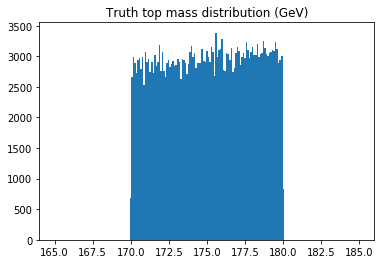

In [236]:
mu_values = np.load(data_dir+ 'part_varmass_6j.npy')[:,0,-1]
plt.hist(mu_values, bins = np.linspace(165,185,200))
plt.title("Truth top mass distribution (GeV)")
plt.show()

In [237]:
mu_min = 170
mu_max = 180
mu_values = np.random.uniform(mu_min, mu_max, len(default_had_mass))
X0 = [(default_had_mass[i], mu_values[i]) for i in range(len(particle_mass))]
Y0 = to_categorical(np.zeros(len(X0)), num_classes=2)

In [238]:
mu_values = np.load(data_dir+ 'part_varmass_6j.npy')[:,0,-1]
X1 = [(truth_had_mass[i], mu_values[i]) for i in range(len(particle_mass))]
Y1 = to_categorical(np.ones(len(X1)), num_classes=2)

In [239]:
X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [240]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

In [259]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
          epochs=200, 
          batch_size = 10,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])

Train on 92336 samples, validate on 23084 samples
Epoch 1/200
92336/92336 [==============================] - 46s 497us/step - loss: 0.6932 - val_loss: 0.6934
Epoch 2/200
92336/92336 [==============================] - 46s 497us/step - loss: 0.6932 - val_loss: 0.6934
Epoch 3/200
92336/92336 [==============================] - 46s 497us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/200
92336/92336 [==============================] - 46s 500us/step - loss: 0.6932 - val_loss: 0.6933
Epoch 5/200
92336/92336 [==============================] - 46s 502us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 6/200
92336/92336 [==============================] - 47s 506us/step - loss: 0.6932 - val_loss: 0.6933
Epoch 7/200
92336/92336 [==============================] - 47s 514us/step - loss: 0.6933 - val_loss: 0.6932
Epoch 8/200
92336/92336 [==============================] - 48s 521us/step - loss: 0.6932 - val_loss: 0.6934
Epoch 9/200
92336/92336 [==============================] - 48s 523us/step - loss: 0.69

In [260]:
X0_test = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,0]
X0_test = np.vstack([X0_test,172.5*np.ones(len(X0_test))]).T
X1_test = np.load(data_dir + 'part_175_0_6j_obs.npy')[:,0]
X1_test = np.vstack([X1_test,175*np.ones(len(X1_test))]).T

In [261]:
# Get predicted probabilities
preds_0 = dctr_model.predict(X0_test, batch_size=1000)
preds_1 = dctr_model.predict(X1_test, batch_size=1000)

In [262]:
weights_0 = preds_0[:,0]/preds_0[:,1]
weights_1 = preds_1[:,0]/preds_1[:,1]

In [263]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

0.99186516
1.0082016
3.6635766
1.0082016


In [264]:
weights_0.shape, X0_test.shape

((57710,), (57710, 2))

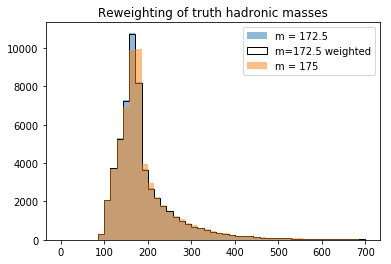

In [265]:
bins = np.linspace(0,700,50)
plt.title("Reweighting of truth hadronic masses")
plt.hist(X0_test[:,0], bins = bins, alpha = 0.5, label = 'm = 172.5')
plt.hist(X0_test[:,0], bins = bins, label = 'm=172.5 weighted', weights=weights_0, histtype='step', color='k')
plt.hist(X1_test[:,0], bins = bins, alpha = 0.5, label = 'm = 175')
plt.legend()
plt.show()

In [266]:
X0_test = np.load(data_dir + 'det_172_5_6j_obs.npy')[:,0]
X0_test = np.vstack([X0_test,172.5*np.ones(len(X0_test))]).T
X1_test = np.load(data_dir + 'det_175_0_6j_obs.npy')[:,0]
X1_test = np.vstack([X1_test,175*np.ones(len(X1_test))]).T

In [267]:
# Get predicted probabilities
preds_0 = dctr_model.predict(X0_test, batch_size=1000)
preds_1 = dctr_model.predict(X1_test, batch_size=1000)

In [268]:
weights_0 = preds_0[:,0]/preds_0[:,1]
weights_1 = preds_1[:,0]/preds_1[:,1]

In [269]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

1.1583763
1.0082016
1.2039391
1.0082016


In [270]:
weights_0.shape, X0_test.shape

((57710,), (57710, 2))

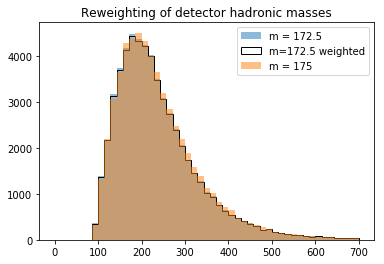

In [273]:
bins = np.linspace(0,700,50)
plt.title("Reweighting of detector hadronic masses")
plt.hist(X0_test[:,0], bins = bins, alpha = 0.5, label = 'm = 172.5')
plt.hist(X0_test[:,0], bins = bins, label = 'm=172.5 weighted', weights=weights_0, histtype='step', color='k')
plt.hist(X1_test[:,0], bins = bins, alpha = 0.5, label = 'm = 175')
plt.legend()
plt.show()